In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#reading from csv and overview
#https://www.kaggle.com/datasets/aaronfriasr/ufc-fighters-statistics?rvi=1

import os
cwd = os.getcwd()
print(cwd)
os.chdir('C://Users//john8/Year 4/Data Analysis')

data= pd.read_csv("spotify-2023.csv", encoding='latin-1')

data.info()
data.head()
data.describe()

#Data cleaning

#Check for null values
data.isnull().sum() 

#in_shazam_charts - 50
#key - 95                                      

#decide to drop rows where above values are null
data.dropna(subset=['in_shazam_charts', 'key'], inplace=True)
data.isnull().sum()

Pearson correlation coefficient between 'streams' and 'in_spotify_playlists': 0.76
Pearson correlation coefficient between 'streams' and 'in_spotify_charts': 0.23
Pearson correlation coefficient between 'streams' and 'in_apple_playlists': 0.67
Pearson correlation coefficient between 'streams' and 'in_apple_charts': 0.24
Pearson correlation coefficient between 'streams' and 'in_deezer_playlists': 0.71
Pearson correlation coefficient between 'streams' and 'in_deezer_charts': 0.27
Pearson correlation coefficient between 'streams' and 'in_shazam_charts': 0.03


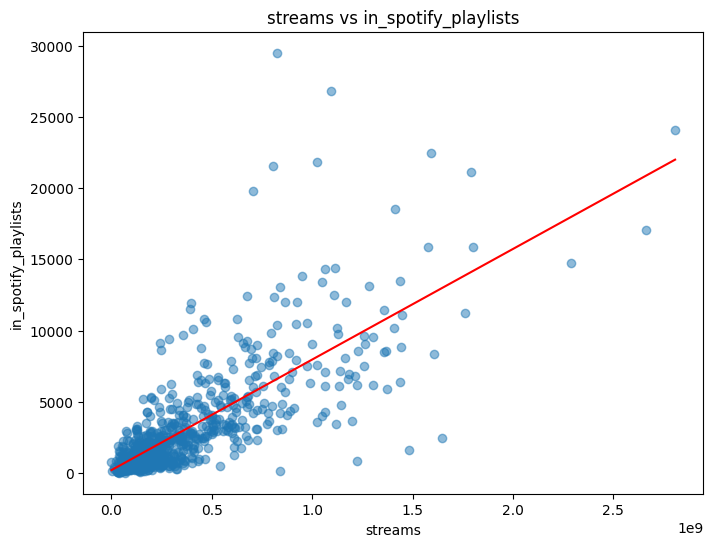

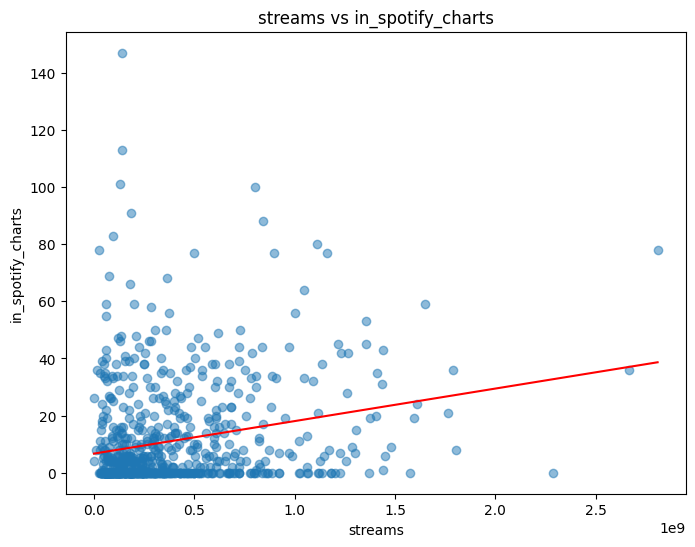

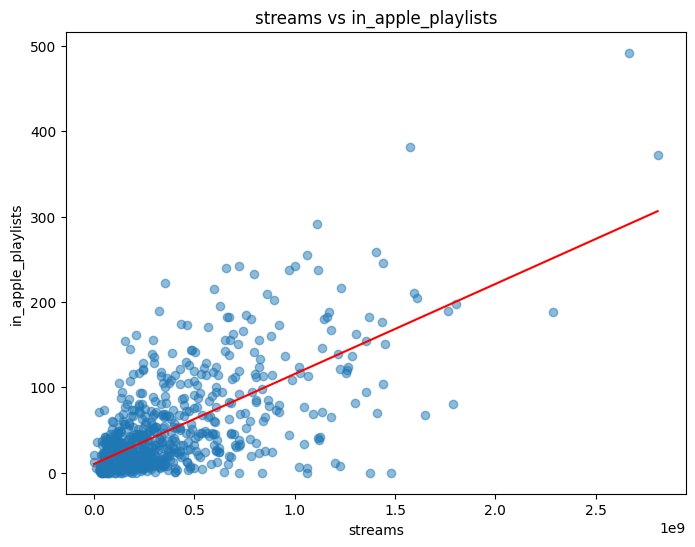

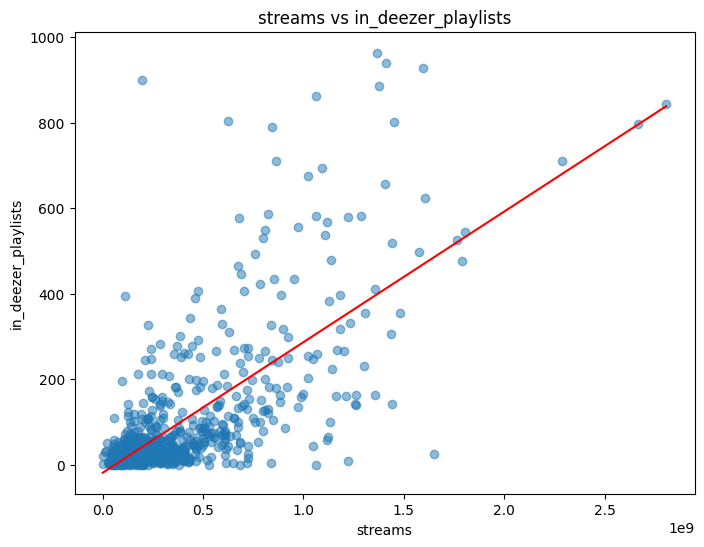

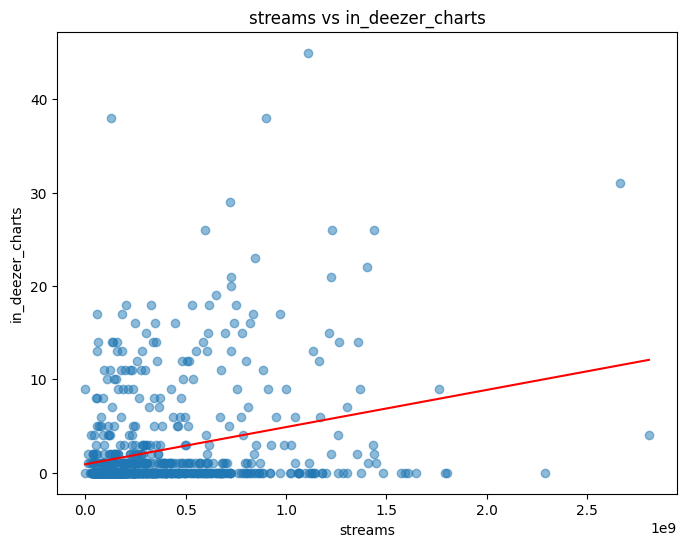

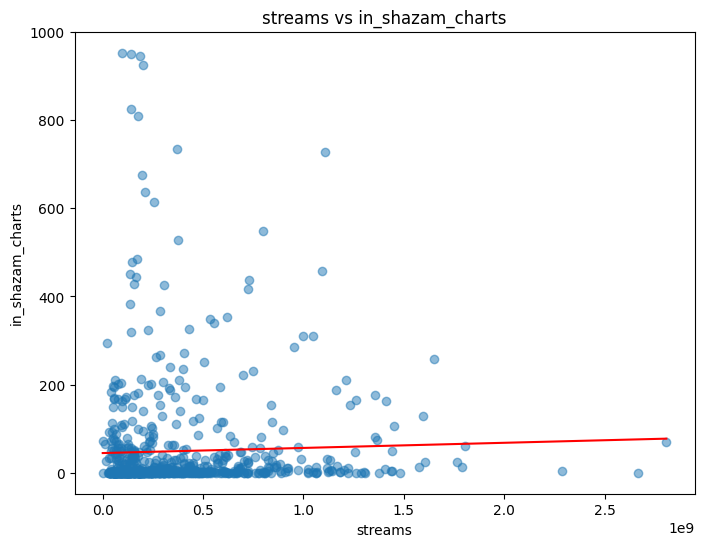

In [8]:
predictor_variables = ['streams']
response_variables = ['in_spotify_playlists',
                      'in_spotify_charts', 'in_apple_playlists', 
                      'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts']

# Convert columns to numeric and handle missing values
data[predictor_variables] = data[predictor_variables].apply(pd.to_numeric, errors='coerce')
data[response_variables] = data[response_variables].apply(pd.to_numeric, errors='coerce')

# Remove rows with NaN or inf values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

for predictor_var in predictor_variables:
    for response_var in response_variables:
        corr_coef, p_value = pearsonr(data[predictor_var], data[response_var])
        print(f"Pearson correlation coefficient between '{predictor_var}' and '{response_var}': {corr_coef:.2f}")

#==================================================

#in_spotify_playlists
#See if theres outliers for the in_spotify_playlists -
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_spotify_playlists)
plt.title("Boxplot of in_spotify_playlists")
plt.ylabel("in_spotify_playlists")
plt.show()

#in_spotify_charts
#See if theres outliers for the in_spotify_charts - 
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_spotify_charts)
plt.title("Boxplot of in_spotify_charts")
plt.ylabel("in_spotify_charts")
plt.show()

#in_apple_playlists
#See if theres outliers for the in_apple_playlists -
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_apple_playlists)
plt.title("Boxplot of in_apple_playlists")
plt.ylabel("in_apple_playlists")
plt.show()

#in_apple_charts
#See if theres outliers for the in_apple_charts -
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_apple_charts)
plt.title("Boxplot of in_apple_charts")
plt.ylabel("in_apple_charts")
plt.show()

#in_deezer_playlists
#See if theres outliers for the in_deezer_playlists - 
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_deezer_playlists)
plt.title("Boxplot of in_deezer_playlists")
plt.ylabel("in_deezer_playlists")
plt.show()

#in_deezer_charts
#See if theres outliers for the in_deezer_charts -
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_deezer_charts)
plt.title("Boxplot of in_deezer_charts")
plt.ylabel("in_deezer_charts")
plt.show()

#in_shazam_charts
#See if theres outliers for the in_shazam_charts - its ok
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(x=data.in_shazam_charts)
plt.title("Boxplot of in_shazam_charts")
plt.ylabel("in_shazam_charts")
plt.show()

#------------------------------------------

# Scatter plot of streams vs in_spotify_playlists
plt.figure(figsize=(8, 6))
plt.title("streams vs in_spotify_playlists")
plt.xlabel("streams")
plt.ylabel("in_spotify_playlists")
plt.scatter(data['streams'], data['in_spotify_playlists'], alpha=0.5)
plt.plot(np.unique(data['streams']), np.poly1d(np.polyfit(data['streams'], data['in_spotify_playlists'], 1))(np.unique(data['streams'])), color='red')


# Scatter plot of streams vs in_spotify_charts
plt.figure(figsize=(8, 6))
plt.title("streams vs in_spotify_charts")
plt.xlabel("streams")
plt.ylabel("in_spotify_charts")
plt.scatter(data['streams'], data['in_spotify_charts'], alpha=0.5)
plt.plot(np.unique(data['streams']), np.poly1d(np.polyfit(data['streams'], data['in_spotify_charts'], 1))(np.unique(data['streams'])), color='red')



# Scatter plot of streams vs in_apple_playlists
plt.figure(figsize=(8, 6))
plt.title("streams vs in_apple_playlists")
plt.xlabel("streams")
plt.ylabel("in_apple_playlists")
plt.scatter(data['streams'], data['in_apple_playlists'], alpha=0.5)
plt.plot(np.unique(data['streams']), np.poly1d(np.polyfit(data['streams'], data['in_apple_playlists'], 1))(np.unique(data['streams'])), color='red')


# Scatter plot of wins vs in_deezer_playlists
plt.figure(figsize=(8, 6))
plt.title("streams vs in_deezer_playlists")
plt.xlabel("streams")
plt.ylabel("in_deezer_playlists")
plt.scatter(data['streams'], data['in_deezer_playlists'], alpha=0.5)
plt.plot(np.unique(data['streams']), np.poly1d(np.polyfit(data['streams'], data['in_deezer_playlists'], 1))(np.unique(data['streams'])), color='red')



# Scatter plot of streams vs in_deezer_charts
plt.figure(figsize=(8, 6))
plt.title("streams vs in_deezer_charts")
plt.xlabel("streams")
plt.ylabel("in_deezer_charts")
plt.scatter(data['streams'], data['in_deezer_charts'], alpha=0.5)
plt.plot(np.unique(data['streams']), np.poly1d(np.polyfit(data['streams'], data['in_deezer_charts'], 1))(np.unique(data['streams'])), color='red')



# Scatter plot of streams vs in_shazam_charts
plt.figure(figsize=(8, 6))
plt.title("streams vs in_shazam_charts")
plt.xlabel("streams")
plt.ylabel("in_shazam_charts")
plt.scatter(data['streams'], data['in_shazam_charts'], alpha=0.5)
plt.plot(np.unique(data['streams']), np.poly1d(np.polyfit(data['streams'], data['in_shazam_charts'], 1))(np.unique(data['streams'])), color='red')

